In [111]:
import pyspark as ps
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time
from scipy import stats

In [2]:
spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("df case study") \
            .getOrCreate()
sc = spark.sparkContext

In [3]:
results_df = spark.read.csv('data/2019-Ironman-World-Championship-Results.csv',
                            header=True,
                            quote='"',
                            sep=',',
                            inferSchema=True)

In [4]:
results_df.createOrReplaceTempView('df')

In [5]:
results_df.printSchema()
results_df.columns

root
 |-- BIB: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Division: string (nullable = true)
 |-- Swim: string (nullable = true)
 |-- Bike: string (nullable = true)
 |-- Run: string (nullable = true)
 |-- Overall: string (nullable = true)
 |-- Division Rank: string (nullable = true)
 |-- Gender Rank: string (nullable = true)
 |-- Overall Rank: string (nullable = true)
 |-- T1: string (nullable = true)
 |-- T2: string (nullable = true)



['BIB',
 'Name',
 'Country',
 'Gender',
 'Division',
 'Swim',
 'Bike',
 'Run',
 'Overall',
 'Division Rank',
 'Gender Rank',
 'Overall Rank',
 'T1',
 'T2']

In [6]:
df = results_df.toPandas()
df.drop(['BIB'],axis=1,inplace=True)

# Remove Nones
df.dropna(inplace=True)

df

,Name,Country,Gender,Division,Swim,Bike,Run,Overall,Division Rank,Gender Rank,Overall Rank,T1,T2
0,"Frodeno, Jan",DEU,Male,MPRO,00:47:31,04:16:02,02:42:43,07:51:13,1,1,1,00:01:58,00:02:59
1,"O'donnell, Tim",USA,Male,MPRO,00:47:38,04:18:11,02:49:45,07:59:41,2,2,2,00:02:01,00:02:06
2,"Kienle, Sebastian",DEU,Male,MPRO,00:52:17,04:15:04,02:49:56,08:02:04,3,3,3,00:02:12,00:02:35
3,"Hoffman, Ben",USA,Male,MPRO,00:51:01,04:24:01,02:43:08,08:02:52,4,4,4,00:02:25,00:02:17
4,"Wurf, Cameron",AUS,Male,MPRO,00:52:25,04:14:44,02:55:03,08:06:41,5,5,5,00:02:07,00:02:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2253,"Beavers, Cathy",USA,Female,F65-69,01:45:30,08:25:01,06:18:52,16:50:03,26,609,2262,00:10:25,00:10:15
2254,"Whitehouse, Paul",USA,Male,M70-74,02:06:01,07:51:20,06:29:34,16:50:04,28,1654,2263,00:11:49,00:11:20
2255,"Svoboda-vasquez, Hanna",DEU,Female,F50-54,01:29:33,08:16:27,06:47:42,16:51:03,66,610,2264,00:09:47,00:07:34
2256,"Piasentini, Edgardo",ARG,Male,M65-69,01:42:27,07:42:09,07:13:49,16:53:21,50,1655,2265,00:06:17,00:08:39


In [7]:
# Convert None in Swim, Bike, Run, Overall, T1, and T2 to datetime
# These need to be converted to time intervals NOT datetime (<- time stamp)
# pd.to_timedelta
cols_to_clean = ['Swim', 'Bike', 'Run', 'Overall', 'T1', 'T2']
df[cols_to_clean] = df[cols_to_clean].apply(pd.to_timedelta, unit='s')
df.dtypes

Name                      object
Country                   object
Gender                    object
Division                  object
Swim             timedelta64[ns]
Bike             timedelta64[ns]
Run              timedelta64[ns]
Overall          timedelta64[ns]
Division Rank             object
Gender Rank               object
Overall Rank              object
T1               timedelta64[ns]
T2               timedelta64[ns]
dtype: object

In [8]:
# Convert DNS & DNF to 0
df.loc[df['Division Rank'] == 'DNS', 'Division Rank'] = 0
df.loc[df['Division Rank'] == 'DNF', 'Division Rank'] = 0
df.loc[df['Division Rank'] == 'DQ', 'Division Rank'] = 0
df['Division Rank'] = df['Division Rank'].astype(int)

df

,Name,Country,Gender,Division,Swim,Bike,Run,Overall,Division Rank,Gender Rank,Overall Rank,T1,T2
0,"Frodeno, Jan",DEU,Male,MPRO,00:47:31,04:16:02,02:42:43,07:51:13,1,1,1,00:01:58,00:02:59
1,"O'donnell, Tim",USA,Male,MPRO,00:47:38,04:18:11,02:49:45,07:59:41,2,2,2,00:02:01,00:02:06
2,"Kienle, Sebastian",DEU,Male,MPRO,00:52:17,04:15:04,02:49:56,08:02:04,3,3,3,00:02:12,00:02:35
3,"Hoffman, Ben",USA,Male,MPRO,00:51:01,04:24:01,02:43:08,08:02:52,4,4,4,00:02:25,00:02:17
4,"Wurf, Cameron",AUS,Male,MPRO,00:52:25,04:14:44,02:55:03,08:06:41,5,5,5,00:02:07,00:02:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2253,"Beavers, Cathy",USA,Female,F65-69,01:45:30,08:25:01,06:18:52,16:50:03,26,609,2262,00:10:25,00:10:15
2254,"Whitehouse, Paul",USA,Male,M70-74,02:06:01,07:51:20,06:29:34,16:50:04,28,1654,2263,00:11:49,00:11:20
2255,"Svoboda-vasquez, Hanna",DEU,Female,F50-54,01:29:33,08:16:27,06:47:42,16:51:03,66,610,2264,00:09:47,00:07:34
2256,"Piasentini, Edgardo",ARG,Male,M65-69,01:42:27,07:42:09,07:13:49,16:53:21,50,1655,2265,00:06:17,00:08:39


In [9]:
male_results = df[df['Gender'] == 'Male']
male_pro = male_results[male_results['Division'] == 'MPRO']
male_agegroups = male_results[male_results['Division'] != 'MPRO']
'''
male_F18 = male_results[male_results['Division'] == 'M18-24']
male_F25 = male_results[male_results['Division'] == 'M25-29']
male_F30 = male_results[male_results['Division'] == 'M30-34']
male_F35 = male_results[male_results['Division'] == 'M35-39']
male_F40 = male_results[male_results['Division'] == 'M40-44']
male_F45 = male_results[male_results['Division'] == 'M45-49']
male_F50 = male_results[male_results['Division'] == 'M50-54']
male_F55 = male_results[male_results['Division'] == 'M55-59']
male_F60 = male_results[male_results['Division'] == 'M60-64']
male_F65 = male_results[male_results['Division'] == 'M66-69']
male_F70 = male_results[male_results['Division'] == 'M70-74']
male_F75 = male_results[male_results['Division'] == 'M75-79']
male_F80 = male_results[male_results['Division'] == 'M80-84']'''

"\nmale_F18 = male_results[male_results['Division'] == 'M18-24']\nmale_F25 = male_results[male_results['Division'] == 'M25-29']\nmale_F30 = male_results[male_results['Division'] == 'M30-34']\nmale_F35 = male_results[male_results['Division'] == 'M35-39']\nmale_F40 = male_results[male_results['Division'] == 'M40-44']\nmale_F45 = male_results[male_results['Division'] == 'M45-49']\nmale_F50 = male_results[male_results['Division'] == 'M50-54']\nmale_F55 = male_results[male_results['Division'] == 'M55-59']\nmale_F60 = male_results[male_results['Division'] == 'M60-64']\nmale_F65 = male_results[male_results['Division'] == 'M66-69']\nmale_F70 = male_results[male_results['Division'] == 'M70-74']\nmale_F75 = male_results[male_results['Division'] == 'M75-79']\nmale_F80 = male_results[male_results['Division'] == 'M80-84']"

In [10]:
fem_results = df[df['Gender'] == 'Female']
fem_pro = fem_results[fem_results['Division'] == 'FPRO']
fem_agegroups = fem_results[fem_results['Division'] != 'FPRO']
'''
fem_F18 = fem_results[fem_results['Division'] == 'F18-24']
fem_F25 = fem_results[fem_results['Division'] == 'F25-29']
fem_F30 = fem_results[fem_results['Division'] == 'F30-34']
fem_F35 = fem_results[fem_results['Division'] == 'F35-39']
fem_F40 = fem_results[fem_results['Division'] == 'F40-44']
fem_F45 = fem_results[fem_results['Division'] == 'F45-49']
fem_F50 = fem_results[fem_results['Division'] == 'F50-54']
fem_F55 = fem_results[fem_results['Division'] == 'F55-59']
fem_F60 = fem_results[fem_results['Division'] == 'F60-64']
fem_F65 = fem_results[fem_results['Division'] == 'F66-69']
fem_F70 = fem_results[fem_results['Division'] == 'F70-74']'''

"\nfem_F18 = fem_results[fem_results['Division'] == 'F18-24']\nfem_F25 = fem_results[fem_results['Division'] == 'F25-29']\nfem_F30 = fem_results[fem_results['Division'] == 'F30-34']\nfem_F35 = fem_results[fem_results['Division'] == 'F35-39']\nfem_F40 = fem_results[fem_results['Division'] == 'F40-44']\nfem_F45 = fem_results[fem_results['Division'] == 'F45-49']\nfem_F50 = fem_results[fem_results['Division'] == 'F50-54']\nfem_F55 = fem_results[fem_results['Division'] == 'F55-59']\nfem_F60 = fem_results[fem_results['Division'] == 'F60-64']\nfem_F65 = fem_results[fem_results['Division'] == 'F66-69']\nfem_F70 = fem_results[fem_results['Division'] == 'F70-74']"

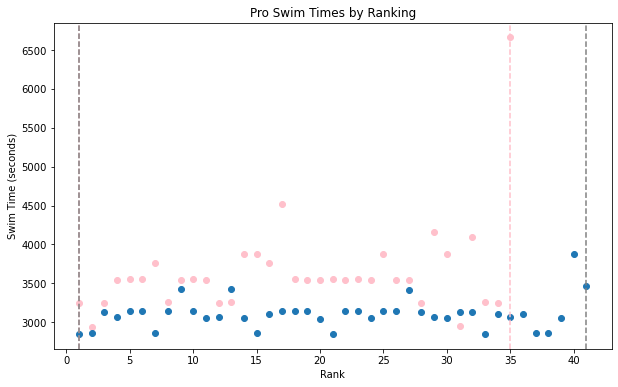

In [11]:
xf = fem_pro['Division Rank']
yf = fem_pro['Swim'].apply(lambda x: x.total_seconds())
xm = male_pro['Division Rank']
ym = male_pro['Swim'].apply(lambda x: x.total_seconds())

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(xf, yf, c='pink')
ax.scatter(xm, ym)

ax.set_title('Pro Swim Times by Ranking')
ax.set_xlabel('Rank')
ax.set_ylabel('Swim Time (seconds)')

ax.axvline(1, c='pink', linestyle="--")
ax.axvline(xf.max(), c='pink', linestyle="--")
ax.axvline(1, c='grey', linestyle="--")
ax.axvline(xm.max(), c='grey', linestyle="--")

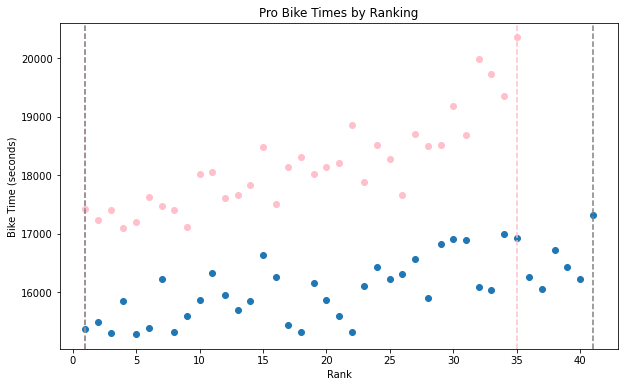

In [12]:
xf = fem_pro['Division Rank']
yf = fem_pro['Bike'].apply(lambda x: x.total_seconds())
xm = male_pro['Division Rank']
ym = male_pro['Bike'].apply(lambda x: x.total_seconds())

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(xf, yf, c='pink')
ax.scatter(xm, ym)

ax.set_title('Pro Bike Times by Ranking')
ax.set_xlabel('Rank')
ax.set_ylabel('Bike Time (seconds)')

ax.axvline(1, c='pink', linestyle="--")
ax.axvline(xf.max(), c='pink', linestyle="--")
ax.axvline(1, c='grey', linestyle="--")
ax.axvline(xm.max(), c='grey', linestyle="--")

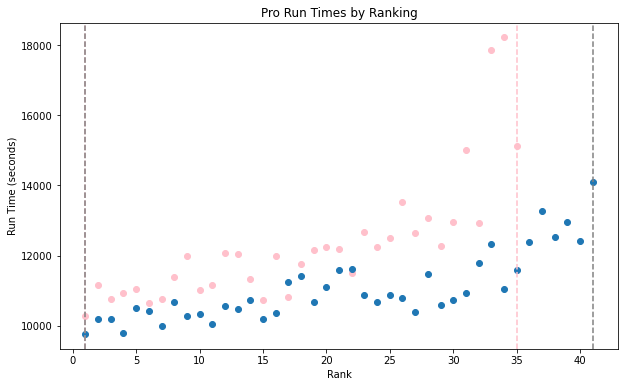

In [13]:
xf = fem_pro['Division Rank']
yf = fem_pro['Run'].apply(lambda x: x.total_seconds())
xm = male_pro['Division Rank']
ym = male_pro['Run'].apply(lambda x: x.total_seconds())

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(xf, yf, c='pink')
ax.scatter(xm, ym)

ax.set_title('Pro Run Times by Ranking')
ax.set_xlabel('Rank')
ax.set_ylabel('Run Time (seconds)')

ax.axvline(1, c='pink', linestyle="--")
ax.axvline(xf.max(), c='pink', linestyle="--")
ax.axvline(1, c='grey', linestyle="--")
ax.axvline(xm.max(), c='grey', linestyle="--")

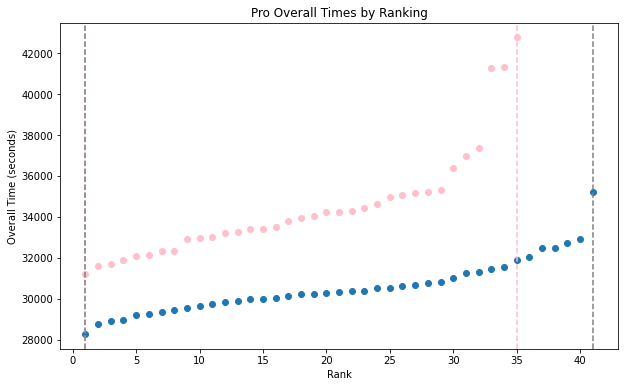

In [14]:
xf = fem_pro['Division Rank']
yf = fem_pro['Overall'].apply(lambda x: x.total_seconds())
xm = male_pro['Division Rank']
ym = male_pro['Overall'].apply(lambda x: x.total_seconds())

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(xf, yf, c='pink')
ax.scatter(xm, ym)

ax.set_title('Pro Overall Times by Ranking')
ax.set_xlabel('Rank')
ax.set_ylabel('Overall Time (seconds)')

ax.axvline(1, c='pink', linestyle="--")
ax.axvline(xf.max(), c='pink', linestyle="--")
ax.axvline(1, c='grey', linestyle="--")
ax.axvline(xm.max(), c='grey', linestyle="--")

## Big Q: what effects do fast Swim, Bike, or Run times have on Overall Ranking?

In [15]:
import seaborn as sns

In [16]:
df['Bool_Gender'] = df['Gender'] == "Female"
df['Bool_Gender'].astype(int)

0       0
1       0
2       0
3       0
4       0
       ..
2253    1
2254    0
2255    1
2256    0
2257    0
Name: Bool_Gender, Length: 2256, dtype: int64

In [17]:
heatmap_cols = ['Swim', 'Bike', 'Run', 'Overall', 'Bool_Gender', 'Division Rank']

def timedeltToSec(df, col):
    return df[col].apply(lambda x: x.total_seconds())

In [18]:
df['Swim'] = timedeltToSec(df, 'Swim')
df['Bike'] = timedeltToSec(df, 'Bike')
df['Run'] = timedeltToSec(df, 'Run')
df['Overall'] = timedeltToSec(df, 'Overall')

In [19]:
heat_df = df[heatmap_cols]

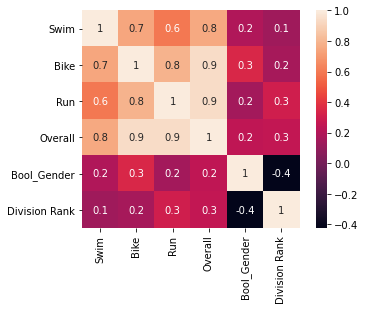

In [20]:
sns.heatmap(heat_df.corr(), annot = True, fmt='.1g', square=True)

Based on the correlation map, we can see that all three sports: Swim, Bike, & Run have high correlations with the Overall Time but Swim is slightly less correlated than the other two sports. Run has the greatest correlation of the three sports on how athletes rank in their division. 

I'd like to take a look at just the pros.

<ipython-input-304-d15dfb87c2b1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_pros['Bool_Gender'] = (df['Division'] == "FPRO")


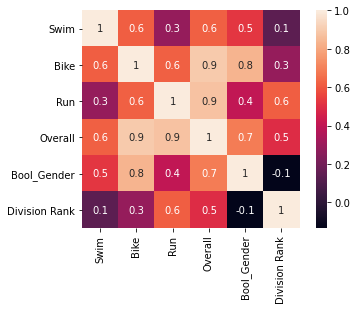

In [304]:
pro_mask = (df['Division'] == 'MPRO') | (df['Division'] == 'FPRO')
heat_pros = df[pro_mask]
heat_pros['Bool_Gender'] = (df['Division'] == "FPRO")
heat_pros['Bool_Gender'].astype(int)
plot = heat_pros[heatmap_cols]
sns.heatmap(plot.corr(), annot = True, fmt='.1g', square=True)

Swim has a much lower correlation in the pro division where Bike and Run times are highly correlated with Overall finish times. I think this has to do with the total distance of the event, 226.31km, and how that's divided amongst the three sports. Swim accounts for 1.7% of the entire race, Bike 79.6%, and Run is 18.7%. Meaning Bike and Run times dominate the Overall time.

Some questions that come up from this heatmap:

Why Run has the greatest correlation (0.6) of the three sports with Division Rank?

What relationship does Gender have with the sports?

Assume that pro triathletes competing in Kona are i.i.d. samples of all possible pro triathletes. Computing statistics of this random sample: the sample mean. Since n > 30, Law of Large Numbers is valid and we can assume the distribution of sample means will be approximately normally distributed.

I would like to use the Maximum Likelihood Estimation to find the variance of each sample: Swim, Bike, and Run given the sample means generated by their data.

Steps:
1. Clean data further: Booleans for Gender
2. Isolate np.arrays of each category
3. Scatterplot each!
4. Calculate means for each category
5. Randomly sample from arrays of each category to generate np.arrays of means

Hyp Test: Does a slow or fast Swim time lead to a better Division Rank?

# Hyp Test: How fast a Swim, Bike, or Run time qualifies you as pro?

Here we are assuming all three sports are i.i.d. although that may not necessarily be true in real life where an exhausting Swim could lead to slower Bike and Run times, or a particularly strong biker is a weak runner.

In [199]:
swim = df['Swim']
print(f'Randomly draw, with replacement to produce many random samplings of size {len(swim)} from Swim')
print(f'Sample mean (in minutes): {round(swim.mean()/60, 2)}, standard deviation (minutes): {round(swim.std()/60, 2)}, and variance (min): {round(swim.var()/60, 2)}')

Randomly draw, with replacement to produce many random samplings of size 2256 from Swim
Sample mean (in minutes): 72.25, standard deviation (minutes): 13.14, and variance (min): 10354.7


Notes to self:
    
Need 95% Confidence Interval for Pro Medians <- where median is, not a range of pro times

Lower 90th percentile - looking for lowest 10% in all samples 

i.e. if you race x or faster => pro ; bootstrap on bottom 10% of race times => 95% confidence interval on 10%

1. 90% percentile (isntead of median 50%) - might need to flip to 10%
2. Bootstrap - find 95% confidence interval
    yield high & low times for bottom 10% of pros
3. Compare to Division Ranks - if you do better than low 10%, you'll be amongst the pros!

In [174]:
def times(df, sport):
    '''
    Returns an array of randomly chosen times according to the sport specified.
    
    Parameters:
    df: dataFrame pulling from
    sport: string: 'Swim', 'Bike', 'Run', or 'Overall'
    
    Returns:
    np.array of length 2434, with time entries in seconds
    '''
    l = df[sport]
    return np.random.choice(df[sport], size=len(l), replace=True)

In [207]:
def bootstrap_statistic(df, sport, samples, statistic):
    '''
    Returns an array of bootstrapped statistics
    
    Parameters:
    df: dataFrame pulling from
    sport: string: 'Swim', 'Bike', 'Run', or 'Overall'
    samples: int: # of samples desired
    statistic: string: statistic to calculate on sample i.e. np.median, np.var, np.std
    '''
    statistics = []
    for i in range(samples):
            samp = times(df, sport)
            statistics.append(statistic(samp))
    return statistics

In [211]:
def bootstrap_percentile(df, sport, samples, percent, statistic=np.percentile):
    statistics = []
    for i in range(samples):
        samp = times(df, sport)
        statistics.append(statistic(samp, percent))
    return statistics

In [219]:
bootstrap_swim = bootstrap_statistic(df, 'Swim', 10000, np.median)
bootstrap_bike = bootstrap_statistic(df, 'Bike', 10000, np.median)
bootstrap_run = bootstrap_statistic(df, 'Run', 10000, np.median)

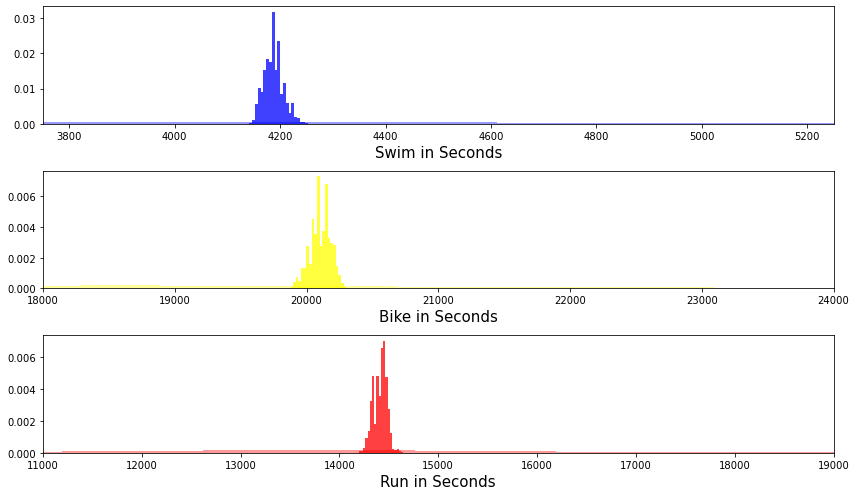

In [300]:
fig, ax = plt.subplots(3, 1, figsize=(12,7))

ax[0].hist(bootstrap_swim, bins=25, density=True, color='blue', alpha=0.75, label='Bootstrap Sample Swim Time Medians')
ax[0].hist(times(df, 'Swim'), bins=25, density=True, color="blue", alpha=0.4, label="Sample Swims")
ax[0].set_xbound(3750,5250)
ax[0].set_xlabel('Swim in Seconds', fontsize=15)

ax[1].hist(bootstrap_bike, bins=25, density=True, color='yellow', alpha=0.75, label='Bootstrap Sample Bike Time Medians')
ax[1].hist(times(df, 'Bike'), bins=25, density=True, color="yellow", alpha=0.4, label="Sample Swims")
ax[1].set_xbound(18000, 24000)
ax[1].set_xlabel('Bike in Seconds', fontsize=15)

ax[2].hist(bootstrap_run, bins=25, density=True, color='red', alpha=0.75, label='Bootstrap Sample Run Time Medians')
ax[2].hist(times(df, 'Run'), bins=25, density=True, color="red", alpha=0.4, label="Sample Runs")
ax[2].set_xbound(11000, 19000)
ax[2].set_xlabel('Run in Seconds', fontsize=15)

plt.tight_layout()

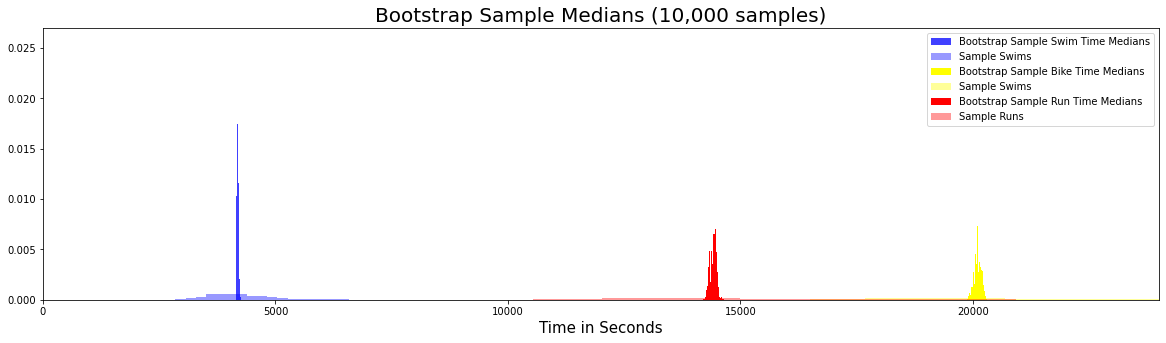

In [225]:
fig,ax = plt.subplots(1, figsize=(20,5))

ax.hist(bootstrap_swim, bins=25, density=True, color='blue', alpha = 0.75, label='Bootstrap Sample Swim Time Medians')
ax.hist(times(df, 'Swim'), bins=25, density=True, color="blue", alpha=0.4, label="Sample Swims")

ax.hist(bootstrap_bike, bins=25, density=True, color='yellow', label='Bootstrap Sample Bike Time Medians')
ax.hist(times(df, 'Bike'), bins=25, density=True, color="yellow", alpha=0.4, label="Sample Swims")

ax.hist(bootstrap_run, bins=25, density=True, color='red', label='Bootstrap Sample Run Time Medians')
ax.hist(times(df, 'Run'), bins=25, density=True, color="red", alpha=0.4, label="Sample Runs")

ax.set_title("Bootstrap Sample Medians (10,000 samples)", fontsize = 20)
ax.set_xlabel('Time in Seconds', fontsize=15)
ax.set_xbound(0, 24000)
ax.set_ybound(0, .027)
ax.legend()

# To test for how fast a Swim, Bike, or Run time qualifies you as a "pro", I will bootstrap from the pros only.

Then I will test fast Division times against a p-value generated from the pro's medians.

First, Female Pros:

In [108]:
fem_pro = df[df['Division'] == 'FPRO']
fem_pro.describe()

,Swim,Bike,Run,Overall,Division Rank,T1,T2
count,35.000000,35.000000,35.000000,35.000000,35.000000,35,35
mean,3644.857143,18177.628571,12310.828571,34468.142857,18.000000,0 days 00:02:27.628571,0 days 00:03:07.200000
std,617.123552,815.454514,1809.676758,2711.442932,10.246951,0 days 00:00:33.468234,0 days 00:00:49.487253
min,2942.000000,17104.000000,10267.000000,31210.000000,1.000000,0 days 00:02:02,0 days 00:02:13
25%,3260.500000,17554.000000,11102.000000,32928.000000,9.500000,0 days 00:02:12,0 days 00:02:35
50%,3546.000000,18047.000000,12036.000000,33963.000000,18.000000,0 days 00:02:22,0 days 00:02:56
75%,3765.000000,18523.500000,12668.000000,35123.000000,26.500000,0 days 00:02:28,0 days 00:03:15.500000
max,6662.000000,20356.000000,18216.000000,42765.000000,35.000000,0 days 00:05:24,0 days 00:05:50


In [231]:
bootstrap_fpro_swim = bootstrap_statistic(fem_pro, 'Swim', 1000, np.median)

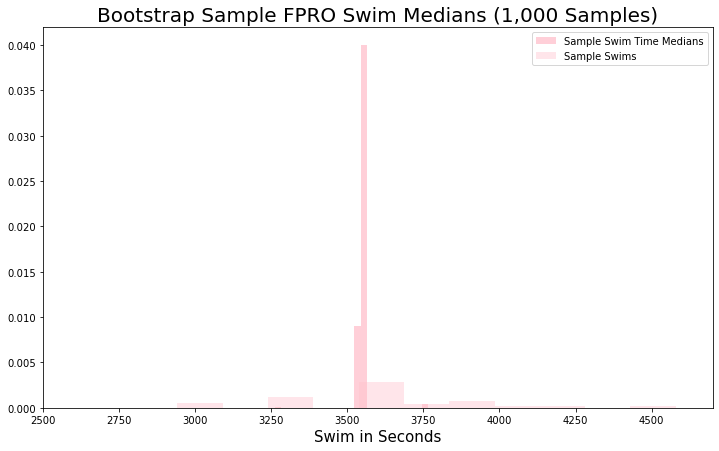

In [232]:
fig, ax = plt.subplots(1, figsize=(12,7))

ax.hist(bootstrap_fpro_swim, bins=25, density=True, color='pink', alpha=0.75, label='Sample Swim Time Medians')
ax.hist(times(fem_pro, 'Swim'), bins=25, density=True, color="pink", alpha=0.4, label="Sample Swims")
ax.set_title('Bootstrap Sample FPRO Swim Medians (1,000 Samples)', fontsize=20)
ax.set_xbound(2500, 4700)
ax.set_xlabel('Swim in Seconds', fontsize=15)
ax.legend()

In [233]:
std_samp = np.std(times(fem_pro, 'Swim'))
std_b_medians = np.std(bootstrap_fpro_swim)
print(f'Standard Deviation of Sample (minutes): {round(std_samp/60, 2)} and standard deviation of sample medians (minutes): {round(std_b_medians/60,2)}')


Standard Deviation of Sample (minutes): 13.1 and standard deviation of sample medians (minutes): 0.41


In [213]:
fem_pro_p = bootstrap_percentile(fem_pro, 'Swim', 1000, 75)

In [218]:
left = np.percentile(fem_pro_p, 2.5)
right = np.percentile(fem_pro_p, 97.5)
print(f'Bootstrap Confidence Interval for Population 75th Percentile (minutes): [{round(left/60, 2)}, {round(right/60,2)}]')

Bootstrap Confidence Interval for Population 75th Percentile (minutes): [59.18, 64.63]


Text(0.5, 0, 'Swim in Seconds')

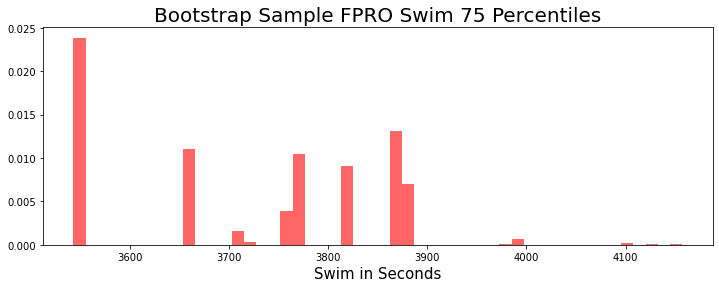

In [297]:
fig, ax = plt.subplots(1, figsize=(12,4))

ax.hist(fem_pro_p, bins=50, density=True, color='r', alpha=0.6)
ax.set_title('Bootstrap Sample FPRO Swim 75 Percentiles', fontsize=20)
ax.set_xlabel('Swim in Seconds', fontsize=15)

In [239]:
male_pro = df[df['Division'] == 'MPRO']
bootstrap_mpro_swim = bootstrap_statistic(male_pro, 'Swim', 1000, np.median)

Text(0.5, 0, 'Swim in Seconds')

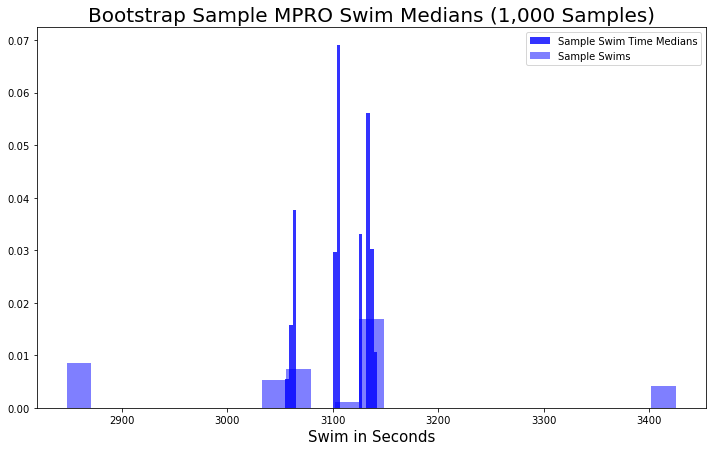

In [240]:
fig, ax = plt.subplots(1, figsize=(12,7))

ax.hist(bootstrap_mpro_swim, bins=25, density=True, color='blue', alpha=0.8, label='Sample Swim Time Medians')
ax.hist(times(male_pro, 'Swim'), bins=25, density=True, color="blue", alpha=0.5, label="Sample Swims")
ax.set_title('Bootstrap Sample MPRO Swim Medians (1,000 Samples)', fontsize=20)
ax.legend()
ax.set_xlabel('Swim in Seconds', fontsize=15)

In [279]:
male_pro_p = bootstrap_percentile(male_pro, 'Swim', 1000, 75)

In [280]:
left = np.percentile(male_pro_p, 2.5)
right = np.percentile(male_pro_p, 97.5)
# 95 % Confident that this is our 75th Percentile
print(f'Bootstrap Confidence Interval for Population 75th Percentile (minutes): [{round(left/60, 2)}, {round(right/60,2)}]')

Bootstrap Confidence Interval for Population 75th Percentile (minutes): [0.87, 0.87]


Text(0.5, 0, 'Swim in Seconds')

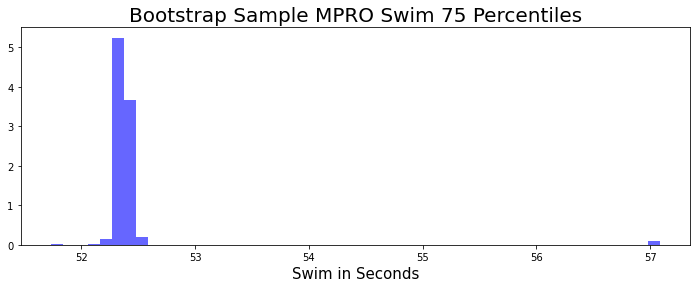

In [296]:
fig, ax = plt.subplots(1, figsize=(12,4))

ax.hist(male_pro_p, bins=50, density=True, color='b', alpha=0.6)
ax.set_title('Bootstrap Sample MPRO Swim 75 Percentiles', fontsize=20)
ax.set_xlabel('Swim in Seconds', fontsize=15)

In [251]:
# *********************** GO BACK AND COMBINE FEM & MALE PRO GRAPHS!!! ************************* 

In [282]:
fem_pro_10p = bootstrap_percentile(fem_pro, 'Swim', 1000, 10)
male_pro_10p = bootstrap_percentile(male_pro, 'Swim', 1000, 10)

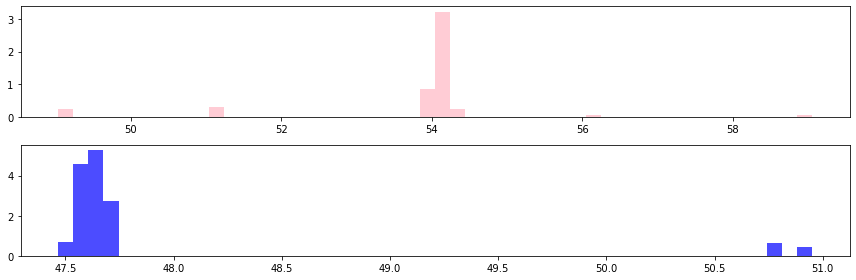

In [277]:
fig, ax = plt.subplots(2, 1, figsize=(12,4))

ax[0].hist(fem_pro_10p, bins=50, density=True, color='pink', alpha=0.8, label='FPRO')
ax[1].hist(male_pro_10p, bins=50, density=True, color='b', alpha=0.7, label='MPRO')
plt.tight_layout()

In [376]:
# 95 % Confident that this is our 10th Percentile

left_swimf10p = np.percentile(fem_pro_10p, 2.5)
right_swimf10p = np.percentile(fem_pro_10p, 97.5)

left_swimm10p = np.percentile(male_pro_10p, 2.5)
right_swimm10p = np.percentile(male_pro_10p, 97.5)

print(f'Female Pro Swim Times Bootstrap Confidence Interval for Population 10th Percentile (minutes): [{round(left_swimf10p, 2)}, {round(right_swimf10p,2)}]')

print(f'Male Pro Swim Times Bootstrap Confidence Interval for Population 10th Percentile (minutes): [{round(left_swimm10p, 2)}, {round(right_swimm10p,2)}]')


Female Pro Swim Times Bootstrap Confidence Interval for Population 10th Percentile (minutes): [49.13, 54.33]
Male Pro Swim Times Bootstrap Confidence Interval for Population 10th Percentile (minutes): [47.52, 50.88]


In effort to answer the question, how fast do you need to swim to be considered a pro? We can see our 95% confidence interval for the 10th percentile of Female and Male Pro swim times. Therefore, if you swim in, or faster than this 10th percentile, I am 95% confidence you are considered a pro swimming triathlete!

# Let's answer the same question for biking and running, how fast do you need to Bike and Run to be considered a pro?

In [377]:
fem_bike_10p = bootstrap_percentile(fem_pro, 'Bike', 1000, 10)
male_bike_10p = bootstrap_percentile(male_pro, 'Bike', 1000, 10)

left_bikef10p = np.percentile(fem_bike_10p, 2.5)
right_bikef10p = np.percentile(fem_bike_10p, 97.5)

left_bikem10p = np.percentile(male_bike_10p, 2.5)
right_bikem10p = np.percentile(male_bike_10p, 97.5)

print(f'Female Pro Bike Times Bootstrap Confidence Interval for Population 10th Percentile (hours): [{round(left_bikef10p/3600, 2)}, {round(right_bikef10p/3600,2)}]')

print(f'Male Pro Bike Times Bootstrap Confidence Interval for Population 10th Percentile (hours): [{round(left_bikem10p/3600, 2)}, {round(right_bikem10p/3600,2)}]')


Female Pro Bike Times Bootstrap Confidence Interval for Population 10th Percentile (hours): [4.75, 4.87]
Male Pro Bike Times Bootstrap Confidence Interval for Population 10th Percentile (hours): [4.25, 4.33]


In [378]:
fem_run_10p = bootstrap_percentile(fem_pro, 'Run', 1000, 10)
male_run_10p = bootstrap_percentile(male_pro, 'Run', 1000, 10)

left_runf10p = np.percentile(fem_run_10p, 2.5)
right_runf10p = np.percentile(fem_run_10p, 97.5)

left_runm10p = np.percentile(male_run_10p, 2.5)
right_runm10p = np.percentile(male_run_10p, 97.5)

print(f'Female Pro Run Times Bootstrap Confidence Interval for Population 10th Percentile (hours): [{round(left_runf10p/3600, 2)}, {round(right_runf10p/3600,2)}]')

print(f'Male Pro Run Times Bootstrap Confidence Interval for Population 10th Percentile (hours): [{round(left_runm10p/3600, 2)}, {round(right_runm10p/3600,2)}]')


Female Pro Run Times Bootstrap Confidence Interval for Population 10th Percentile (hours): [2.96, 3.08]
Male Pro Run Times Bootstrap Confidence Interval for Population 10th Percentile (hours): [2.72, 2.88]


Something to keep in mind is that to be considered pro, you would need to compete in this percentile range (or faster) and have done all triathlon activities in the same order: swim-bike-run.

# Next question: how many amateurs are racing like pros?

In [373]:
m_agegroups_sw = (timedeltToSec(male_agegroups, 'Swim')) / 60
f_agegroups_sw = (timedeltToSec(fem_agegroups, 'Swim')) / 60

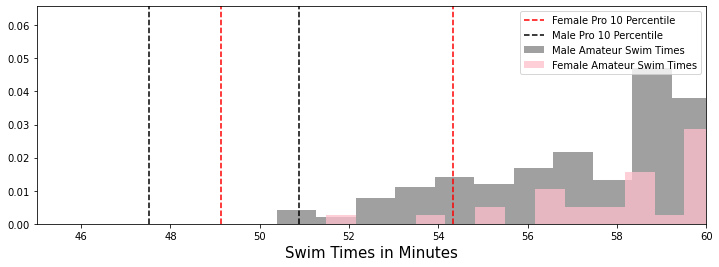

In [379]:
fig, ax = plt.subplots(1, figsize=(12,4))

ax.hist(m_agegroups_sw, bins=100, density=True, color='grey', alpha=0.75, label='Male Amateur Swim Times')
ax.hist(f_agegroups_sw, bins=100, density=True, color='pink', alpha=0.75, label='Female Amateur Swim Times')
ax.axvline(left_swimf10p, c='red', linestyle="--", label='Female Pro 10 Percentile')
ax.axvline(right_swimf10p, c='red', linestyle="--")
ax.axvline(left_swimm10p, c='black', linestyle="--", label='Male Pro 10 Percentile')
ax.axvline(right_swimm10p, c='black', linestyle="--")
ax.set_xbound(45, 60)
ax.set_xlabel('Swim Times in Minutes', fontsize=15)
ax.legend()

In [386]:
m_sw = m_agegroups_sw[m_agegroups_sw <= right_swimm10p]
f_sw = f_agegroups_sw[f_agegroups_sw <= right_swimf10p]
mam_pros_sw = len(m_sw) / len(m_agegroups_sw)
fam_pros_sw = len(f_sw) / len(f_agegroups_sw)
print(f'Percent of male amateurs who swim like pros: {mam_pros_sw}')
print(f'Percent of female amateurs who swim like pros: {fam_pros_sw}')

Percent of male amateurs who swim like pros: 0.002489110143123833
Percent of female amateurs who swim like pros: 0.0034904013961605585


In [375]:
m_agegroups_b = (timedeltToSec(male_agegroups, 'Bike')) / 60
f_agegroups_b = (timedeltToSec(fem_agegroups, 'Bike')) / 60

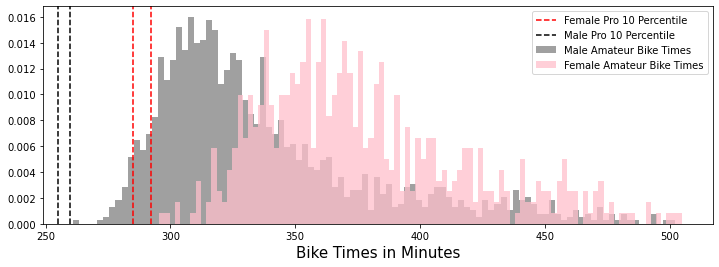

In [385]:
fig, ax = plt.subplots(1, figsize=(12,4))

ax.hist(m_agegroups_b, bins=100, density=True, color='grey', alpha=0.75, label='Male Amateur Bike Times')
ax.hist(f_agegroups_b, bins=100, density=True, color='pink', alpha=0.75, label='Female Amateur Bike Times')
ax.axvline(left_bikef10p/60, c='red', linestyle="--", label='Female Pro 10 Percentile')
ax.axvline(right_bikef10p/60, c='red', linestyle="--")
ax.axvline(left_bikem10p/60, c='black', linestyle="--", label='Male Pro 10 Percentile')
ax.axvline(right_bikem10p/60, c='black', linestyle="--")
ax.set_xlabel('Bike Times in Minutes', fontsize=15)
ax.legend()

In [390]:
m_b = m_agegroups_b[m_agegroups_b <= right_bikem10p]
f_b = f_agegroups_b[f_agegroups_b <= right_bikef10p]
print(m_b)
mam_pros_b = len(m_b) / len(m_agegroups_b)
fam_pros_b = len(f_b) / len(f_agegroups_b)
print(f'Percent of male amateurs who bike like pros: {mam_pros_b}')
print(f'Percent of female amateurs who bike like pros: {fam_pros_b}')

29      277.900000
34      280.833333
36      280.600000
39      290.050000
40      282.733333
           ...    
2250    447.166667
2251    449.850000
2254    471.333333
2256    462.150000
2257    477.400000
Name: Bike, Length: 1607, dtype: float64
Percent of male amateurs who bike like pros: 1.0
Percent of female amateurs who bike like pros: 1.0
